In [18]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.applications import Xception
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import img_to_array, array_to_img
from skimage.transform import resize
from keras.models import Model
from keras.optimizers import Adam

In [2]:
# Wczytanie danych CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Przygotowanie danych (normalizacja i kodowanie kategorialne)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [6]:
import cv2

# Function to resize an image to a specific size
def resize_image(image, size):
    return cv2.resize(image, size)

# Zmiana rozmiaru obrazów z 32x32 na 71x71
new_size = (71, 71)
X_train_resized = np.array((resize_image(img, new_size) for img in X_train))
X_test_resized = np.array((resize_image(img, new_size) for img in X_test))

In [7]:
# Ustalenie wymiarów wejściowych dla Xception
input_shape = X_train_resized.shape[1:]

# Pobranie modelu Xception z wagami nauczonymi na ImageNet
base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

83683744/83683744 [==============================] - 8s 0us/step


In [8]:
# Dodanie nowej warstwy klasyfikacji
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [9]:
# Zamrożenie wag modelu bazowego (warstwy konwolucyjne)
for layer in base_model.layers:
    layer.trainable = False

In [10]:
# Kompilacja modelu
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Trenowanie modelu na nowych danych
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5


2023-10-28 12:58:59.465261: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.


1563/1563 [==============================] - 110s 69ms/step - loss: 1.7065 - accuracy: 0.4069 - val_loss: 1.5707 - val_accuracy: 0.4484
Epoch 2/5
1563/1563 [==============================] - 101s 65ms/step - loss: 1.4793 - accuracy: 0.4754 - val_loss: 1.5235 - val_accuracy: 0.4659
Epoch 3/5
1563/1563 [==============================] - 101s 65ms/step - loss: 1.3598 - accuracy: 0.5179 - val_loss: 1.5205 - val_accuracy: 0.4704
Epoch 4/5
1563/1563 [==============================] - 99s 64ms/step - loss: 1.2454 - accuracy: 0.5615 - val_loss: 1.5297 - val_accuracy: 0.4741
Epoch 5/5
1563/1563 [==============================] - 99s 64ms/step - loss: 1.1319 - accuracy: 0.6047 - val_loss: 1.5631 - val_accuracy: 0.4720


In [19]:
# Oceń model na danych testowych
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

313/313 [==============================] - 16s 50ms/step - loss: 1.5631 - accuracy: 0.4720
Test accuracy: 0.47200000286102295


In [20]:
# Wykonaj predykcje na zestawie testowym
predictions = model.predict(X_test)

313/313 [==============================] - 16s 51ms/step


FAILURE Predicted: 2, True: 3, (0, 0)
FAILURE Predicted: 0, True: 8, (0, 1)
FAILURE Predicted: 6, True: 3, (0, 2)
SUCCESS Predicted: 5, True: 5, (0, 3)
FAILURE Predicted: 4, True: 3, (0, 4)
SUCCESS Predicted: 2, True: 2, (1, 0)
SUCCESS Predicted: 7, True: 7, (1, 1)
SUCCESS Predicted: 0, True: 0, (1, 2)
FAILURE Predicted: 2, True: 3, (1, 3)
FAILURE Predicted: 2, True: 3, (1, 4)
SUCCESS Predicted: 7, True: 7, (2, 0)
SUCCESS Predicted: 0, True: 0, (2, 1)
FAILURE Predicted: 7, True: 1, (2, 2)
FAILURE Predicted: 3, True: 1, (2, 3)
FAILURE Predicted: 6, True: 5, (2, 4)
SUCCESS Predicted: 2, True: 2, (3, 0)
SUCCESS Predicted: 7, True: 7, (3, 1)
SUCCESS Predicted: 0, True: 0, (3, 2)
SUCCESS Predicted: 1, True: 1, (3, 3)
SUCCESS Predicted: 5, True: 5, (3, 4)
FAILURE Predicted: 0, True: 4, (4, 0)
FAILURE Predicted: 4, True: 3, (4, 1)
FAILURE Predicted: 7, True: 2, (4, 2)
SUCCESS Predicted: 2, True: 2, (4, 3)
SUCCESS Predicted: 1, True: 1, (4, 4)
Sample accuracy: 86.666667% (25 samples)


<Figure size 640x480 with 0 Axes>

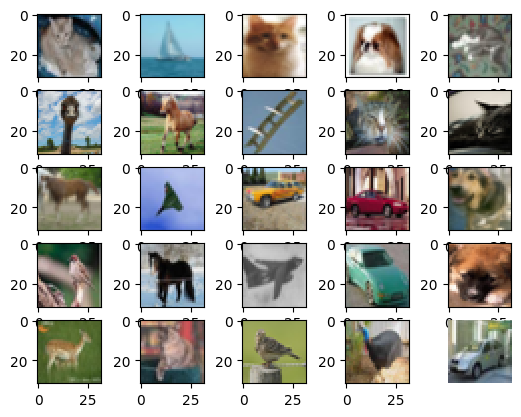

In [51]:
# Wybierz losowy przykład ze zbioru testowego do wizualizacji predykcji
N = 25
rows = 5
sample_indexes = [np.random.randint(0, len(X_test)) for i in range(N)]
predicted_classes = [np.argmax(predictions[sample_index]) for sample_index in sample_indexes]
true_classes = [np.argmax(y_test[sample_index]) for sample_index in sample_indexes]

# Wyświetl obraz i predykcję
plt.figure()
_, axis = plt.subplots(rows, N // rows) 

correct_count = 0

for index, (sample_index, predicted_class) in enumerate(zip(sample_indexes, predicted_classes)):    
    row = index // (N // rows)
    column = index % (N // rows)
    axis[row, column].imshow(X_test[sample_index])
    plt.imshow(X_test[sample_index])
    
    if predicted_class == true_classes[index]:
        mark = 'SUCCESS' 
        correct_count += 1
    else:
        mark = 'FAILURE'
    
    print(f"{mark} Predicted: {predicted_class}, True: {true_classes[index]}, ({row}, {column})")
    
    plt.axis('off')

print(f"Sample accuracy: {correct_count / 15 * 100:2f}% ({N} samples)")
plt.show()
